<a id='top'></a>
# Random Forests

### May 2017

<br>
This is a study for a blog post to appear on [Data Simple](http://luisvalesilva.com/datasimple). It will focus on the theory and scikit-learn implementation of the **Random Forest** machine learning (ML) algorithm.
<br><br>

## Contents

1. [Introduction](#intro)
1. [Decision Trees](#trees)
1. [Ensemble Learning](#ensemble)

<br><br>

<a id='intro'></a>
# 1. Introduction

Random Forests are a popular example of an Ensemble Learning method. Ensemble Learning consists on combining multiple ML models in order to achieve higher predictive performance than could be obtained using either of the individual models alone.

Ensemble Learning methods work best when the models are as diverse as possible, providing complementary predictive performance. One way to achieve this is to combine models built using different ML algorithms, to try to combine models making errors on different training set instances. An alternative approach is to use the same ML algorithm, but to train each model on a different random subset of the training data set. This is the appproach taken by Random Forests: they combine multiple Decision Tree models trained on different subsets of the training data.

The next section provides an overview of the Decision Tree ML algorithm, which is at the core of Random Forests. More on Ensemble Learning theory later. Before moving on, let's generate some toy data using `scikit-learn`'s `make_blobs` function. Let's get a two-dimensional data set with 300 observations evenly split between three classes (let's call them "Yellow", "Blue", and "Red"). I'll use a high-enough standard deviation (parameter `cluster_std`) to blur out the class boundaries a little bit.

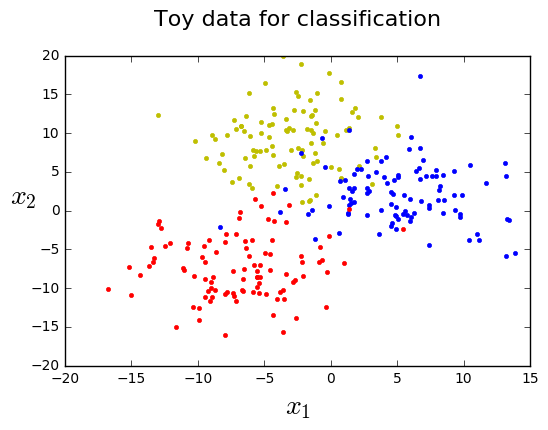

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, n_features=2, centers=3,
                  cluster_std=4, random_state=42)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", marker='.')
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", marker='.')
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "rd", marker='.')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.title("Toy data for classification\n", fontsize=16)

plt.figure(figsize=(4, 3))

#plt.show()

<a id='trees'></a>
# 2. Decision Trees

Decision Trees are powerful ML algorithms capable of fitting complex data sets. The [Wikipedia page](https://en.wikipedia.org/wiki/Decision_tree_learning) on Decision Tree Learning presents the following definition:

> A decision tree is a flow-chart-like structure, where each internal (non-leaf) node denotes a test on an attribute, each branch represents the outcome of a test, and each leaf (or terminal) node holds a class label. The topmost node in a tree is the root node.

In order to classify a data instance, all you need to do is traverse the flow chart, answering all the tests, until you reach a leaf node. Each test will be a question on a specific feature in the data. The class labeling of the leaf node the new instance ends up in is the predicted class.

Let's grow a Decision Tree on our data to take a closer look at how this works in practice. `scikit-learn` makes this ridiculously easy, of course.

In [25]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the classifier class
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

# Grow a Decision Tree
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

We have grown a tree on our 2-D data set. Classifying new examples would be simple:

In [27]:
import numpy as np

def predict_class(data_point, classes=['Yellow', 'Blue', 'Red']):
    # Convert to appropriate numpy array
    data_point = np.array(data_point).reshape(1, -1)
    
    # Classify
    result = tree_clf.predict(data_point)
    
    # Print output
    print('Predicted class for point {}: {}'.format(data_point,
                                                    classes[np.asscalar(result)]))
    
predict_class([-5, 10])
predict_class([10, 5])
predict_class([-10, -10])

Predicted class for point [[-5 10]]: Yellow
Predicted class for point [[10  5]]: Blue
Predicted class for point [[-10 -10]]: Red


We can visualize the Decision Tree model to inspect its structure and see how it makes decisions. We can use the `graphviz` package. We start by generating a graph definition as a `.dot` file, using the `export_graphviz` method. We can then convert the `.dot` file to a `.png` image file.

In [10]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, out_file='tree.dot',
                feature_names=['x1', 'x2'],
                class_names=['Yellow', 'Blue', 'Red'],
                rounded=True, filled=True)

Generate `.png` image using `graphviz` package:

```
$ dot -Tpng tree.dot -o tree.png
```

Here's the tree visualization.

![Tree](tree.png)

We can now see the exact way the model predicts new instance classes. It starts off at the root node, with all 300 training examples split evenly between the three classes, and asks whether feature $x_2$ value is lower than or equal to $-1.3707$. It splits the data in two groups according to the answer and then goes on to ask another question in each of the two following internal nodes. These, in turn, split the data between two groups each. Since we set argument `max_depth=2`, the tree stops here, with four leaf nodes providing the final prediction.

Let's use one of the instances predicted above as an example: $x_1 = -5, x_2 = 10$. The answer to the root node question is `False`, since $x_2 > -1.3707$. The answer to the next question is `True`, since $x_1 <= 0.8566$. This brings us to the leaf node predicting class "Yellow".

This structure allows Decision Trees to estimate class probabilities by simply computing the ratio of training instances belonging to each class in the leaf node. For example, for our predicted instance above this tree estimates it belongs to class "Yellow" with 84.6% probaility (88/104; the predicted class), class "Blue" with 8.7% probability (9/104) and class "Red" with 6.7% probability (7/104).

These rules define axis-parallel decision boundaries, dividing the feature space into a series rectangles, each of which predicts one of the classes.

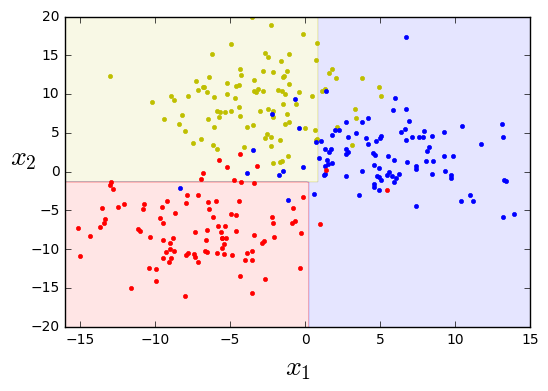

In [61]:
from matplotlib.colors import ListedColormap

def compute_decision_boundaries(clf, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 300)
    x2s = np.linspace(axes[2], axes[3], 300)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    return x1, x2, y_pred

def plot_feature_space(clf, X, y, axes):
    x1, x2, y_pred = compute_decision_boundaries(clf, X, y, axes)
    
    custom_cmap = ListedColormap(['y','b','r'])
    plt.contourf(x1, x2, y_pred, cmap=custom_cmap, alpha=0.1, linewidth=1)

    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", marker='.')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", marker='.')
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "rd", marker='.')
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    plt.figure(figsize=(8, 4))
    

plot_feature_space(tree_clf, X, y, axes=[-16, 15, -20, 20])

#plt.show()

So this is how a Decision Tree model makes predictions. But how is `scikit-learn` actually growing the tree? There are alternatives, but `scikit-learn` uses the Classification And Regression Tree (CART) algorithm. CART works by splitting the training set in two subsets using a single feature $k$ and a threshold $t_k$, such that the split produces the purest subsets (weighted by their size). It then splits the subsets in the same exact way, then the sub-subsets and so on, recursively, until it cannot find a split that will reduce class impurity of the data.

The CART algorithm minimizes the following cost function at each split:

$$ J(k, t_k) = \dfrac{m_{left}}{m}I_{left} + \dfrac{m_{right}}{m}I_{right} $$

$$
with
\begin{cases}
  I_{left/right} \text{ impurity of the left/right subset,}\\
  m_{left/right} \text{ number of instances in the left/right subset.}
\end{cases}
$$

So what is the impurity $I$ measure?


An alternative is to use the "Information gain" measure, based on the concept of entropy from information theory.

<a id='ensemble'></a>
# 3. Ensemble Learning

[Back to top](#top)